In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.integrate import quad
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
t = np.array([40, 50, 60, 70, 80, 90, 100])
p = np.array([0.2453, 0.5459, 1.2151, 2.7042, 6.0184, 13.3943, 29.8096])
x_eval = np.arange(40, 101, 5)

cubic = interp1d(t, p, kind='cubic')
def linear_model(x, params):
  k, b = params
  return k * x + b
def residuals(params, x, y, func):
  return y - func(x, params)
x0 = 0.1, 0.1

def power_model(x, params):
  a, b = params
  return a * x**b

def exp_model(x, params):
  a, b = params
  return a * np.exp(b * x)

line = least_squares(residuals, x0=x0, args=(t, p, linear_model))
linear_params, linear_cost = line.x, line.cost
print(f'Линейная аппроксимация:\
\nk = {linear_params[0]:.3f}, b = {linear_params[1]:.3f}, \
суммарная ошибка = {linear_cost}')

power = least_squares(residuals, x0=x0, args=(t, p, power_model))
power_params, power_cost = power.x, power.cost
print(f'Степенная аппроксимация:\
\na = {power_params[0]:.3e}, b = {power_params[1]:.3f}, \
суммарная ошибка = {power_cost}')

exp = least_squares(residuals, x0=x0, args=(t, p, exp_model))
exp_params, exp_cost = exp.x, exp.cost
print(f'Экспоненциальная аппроксимация:\
\na = {exp_params[0]:.3e}, b = {exp_params[1]:.3f}, \
суммарная ошибка = {exp_cost}')
cubic_spline_eval = cubic(x_eval)
line_eval = linear_params[0] * x_eval + linear_params[1]
power_eval = power_params[0] * x_eval**power_params[1]
exp_eval = exp_params[0] * np.exp(exp_params[1] * x_eval)

Линейная аппроксимация:
k = 0.426, b = -22.094, суммарная ошибка = 95.23045187357138
Степенная аппроксимация:
a = 1.031e-12, b = 6.724, суммарная ошибка = 0.9685890046611318
Экспоненциальная аппроксимация:
a = 1.000e-02, b = 0.080, суммарная ошибка = 4.00890071172602e-09


In [3]:
df_res = pd.DataFrame({'T, °C': x_eval,
                       'Cubic_spline_eval': cubic_spline_eval,
                       'line_eval': line_eval,
                       'power_eval': power_eval,
                       'exp_eval': exp_eval})
df_res

,"T, °C",Cubic_spline_eval,line_eval,power_eval,exp_eval
0,40,0.245300,-5.065993,0.060919,0.245319
1,45,0.370896,-2.937546,0.134489,0.365974
2,50,0.545900,-0.809100,0.273114,0.545970
3,55,0.813054,1.319346,0.518385,0.814494
4,60,1.215100,3.447793,0.930528,1.215085
5,65,1.808452,5.576239,1.593886,1.812697
6,70,2.704200,7.704686,2.623344,2.704232
7,75,4.041664,9.833132,4.171740,4.034249
8,80,6.018400,11.961579,6.438314,6.018405
9,85,8.928541,14.090025,9.678286,8.978425


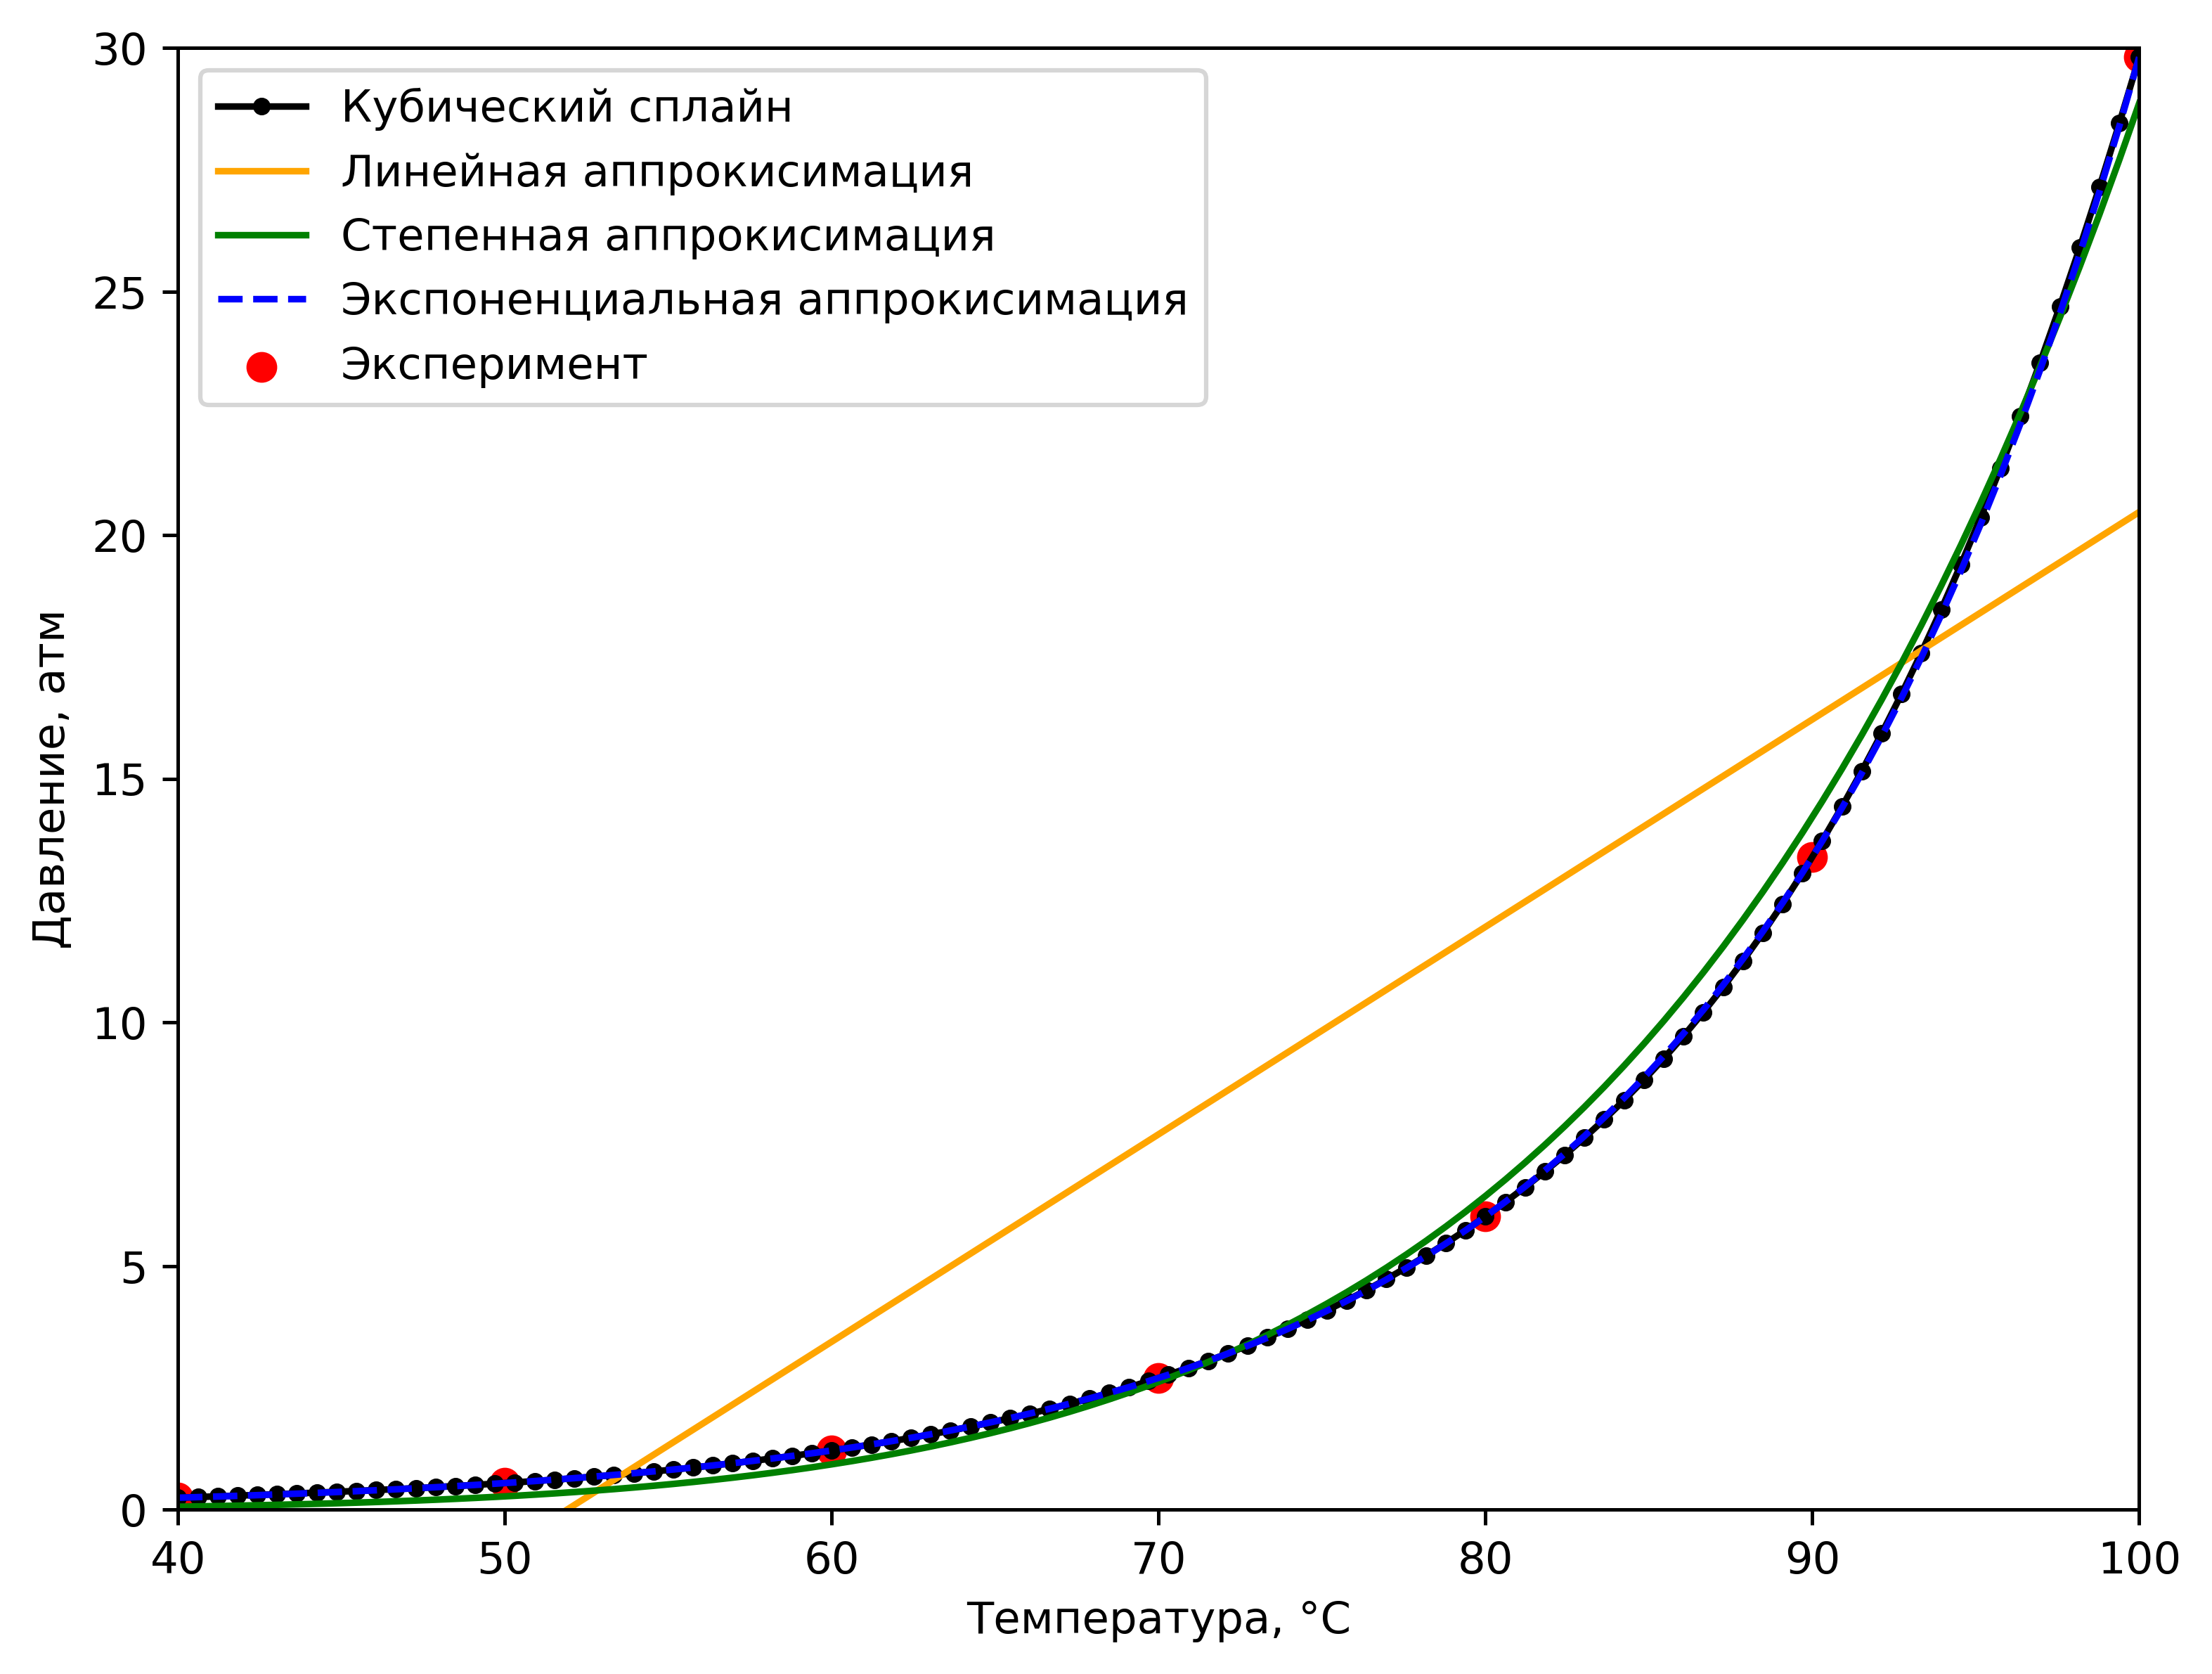

In [4]:
t_space = np.linspace(40, 100, 100)
xlim = [t_space[0], t_space[-1]]
ylim = [0, 30]
fig = plt.figure(figsize=(8,6), dpi=450)
ax = fig.add_subplot(xlim=xlim, ylim=ylim)

ax.plot(t_space, cubic(t_space), '.-k', label='Кубический сплайн')
ax.plot(t_space, linear_params[0] * t_space + linear_params[1], c='orange',
        label='Линейная аппрокисимация')
ax.plot(t_space, power_params[0] * t_space**power_params[1], '-g',
        label='Степенная аппрокисимация')
ax.plot(t_space, exp_params[0] * np.exp(t_space*exp_params[1]), '--b',
        label='Экспоненциальная аппрокисимация')
ax.scatter(t, p, c='r', label='Эксперимент')

ax.legend()
ax.set_ylabel('Давление, атм')
ax.set_xlabel('Температура, °С');

In [5]:
t_start, t_end, t_step = 0, 5, 0.1
t_eval = np.arange(t_start, t_end+t_step, t_step)
start_conc = [0.8, 0.2, 0]
rate_constants = (0.8, 0.96, 0.1)

def derivatives(t, y, *rate_constants):
  c_a, c_b, c_c = y
  k1, k2, k3 = rate_constants
  dca_dt = k1 * c_b
  dcb_dt = -k1 * c_b - k2 * c_b + k3 * c_c
  dcc_dt = k2 * c_b - k3 * c_c

  return dca_dt, dcb_dt, dcc_dt

solution = solve_ivp(derivatives, (t_start, t_end), start_conc,
                     t_eval=t_eval, args=rate_constants)
c_a, c_b, c_c = solution.y[0], solution.y[1], solution.y[2]

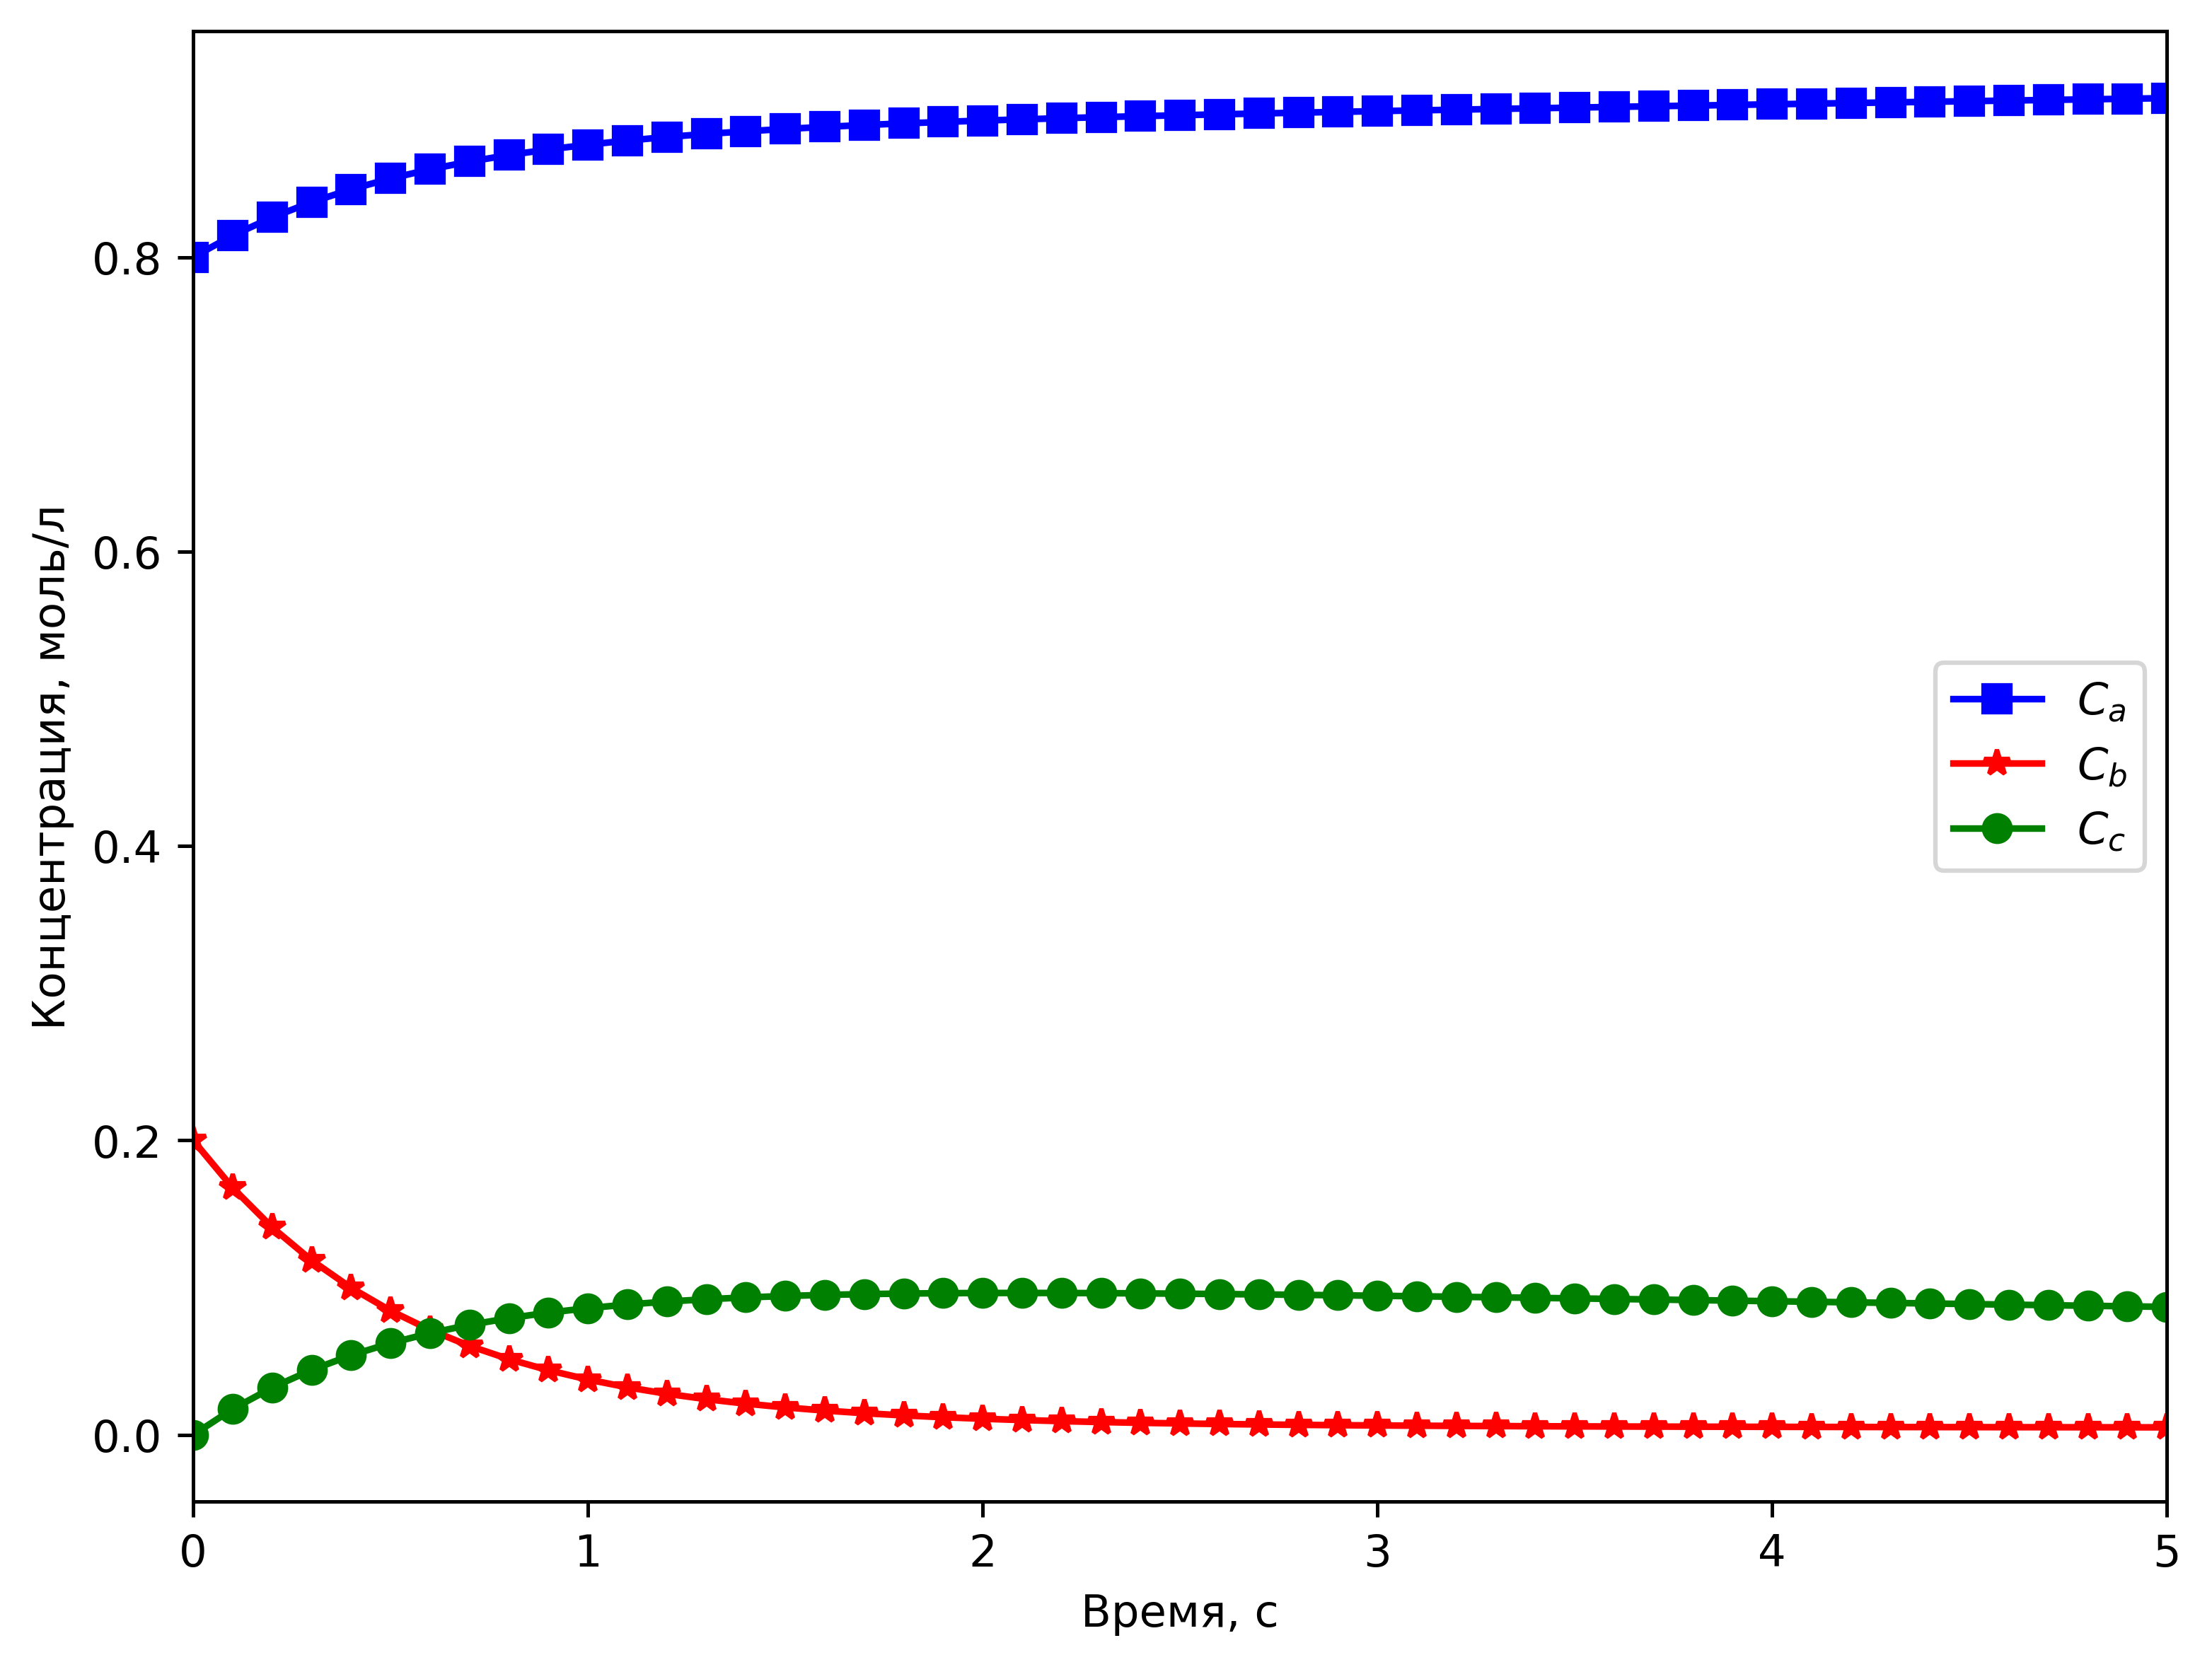

In [6]:
xlim = [t_eval[0], t_eval[-1]]
fig = plt.figure(figsize=(8,6), dpi=450)
ax = fig.add_subplot(xlim=xlim)

ax.plot(t_eval, c_a, 's-b', label='$C_a$')
ax.plot(t_eval, c_b, '*-r', label='$C_b$')
ax.plot(t_eval, c_c, 'o-g', label='$C_c$')

ax.legend()
ax.set_ylabel('Концентрация, моль/л')
ax.set_xlabel('Время, с');

In [7]:
tc = 647.126
eta = 3
a_arr = [7.4305055,
         -24.93618016,
         195.5654567,
         1986.485797,
         -53305.43411,
         505697.1723,
         -2724774.677,
         9167737.673,
         -19622033.78,
         25984725.33,
         -19419431.35,
         6263206.554]

def func(t, tc, eta, a_arr):
  R = 8.314
  tau = 1 - t / tc
  a_arr_len = len(a_arr)
  cv = 0
  for i in range(a_arr_len):
    cv += R * a_arr[i] * tau**(i)
  return eta * cv / t

t_space = np.arange(350, 551, 1)
der = func(t_space, tc, eta, a_arr)
t_space_window = t_space[50:151]
der_window = der[50:151]
area = quad(func, t_space_window[0], t_space_window[-1], args=(tc, eta, a_arr))

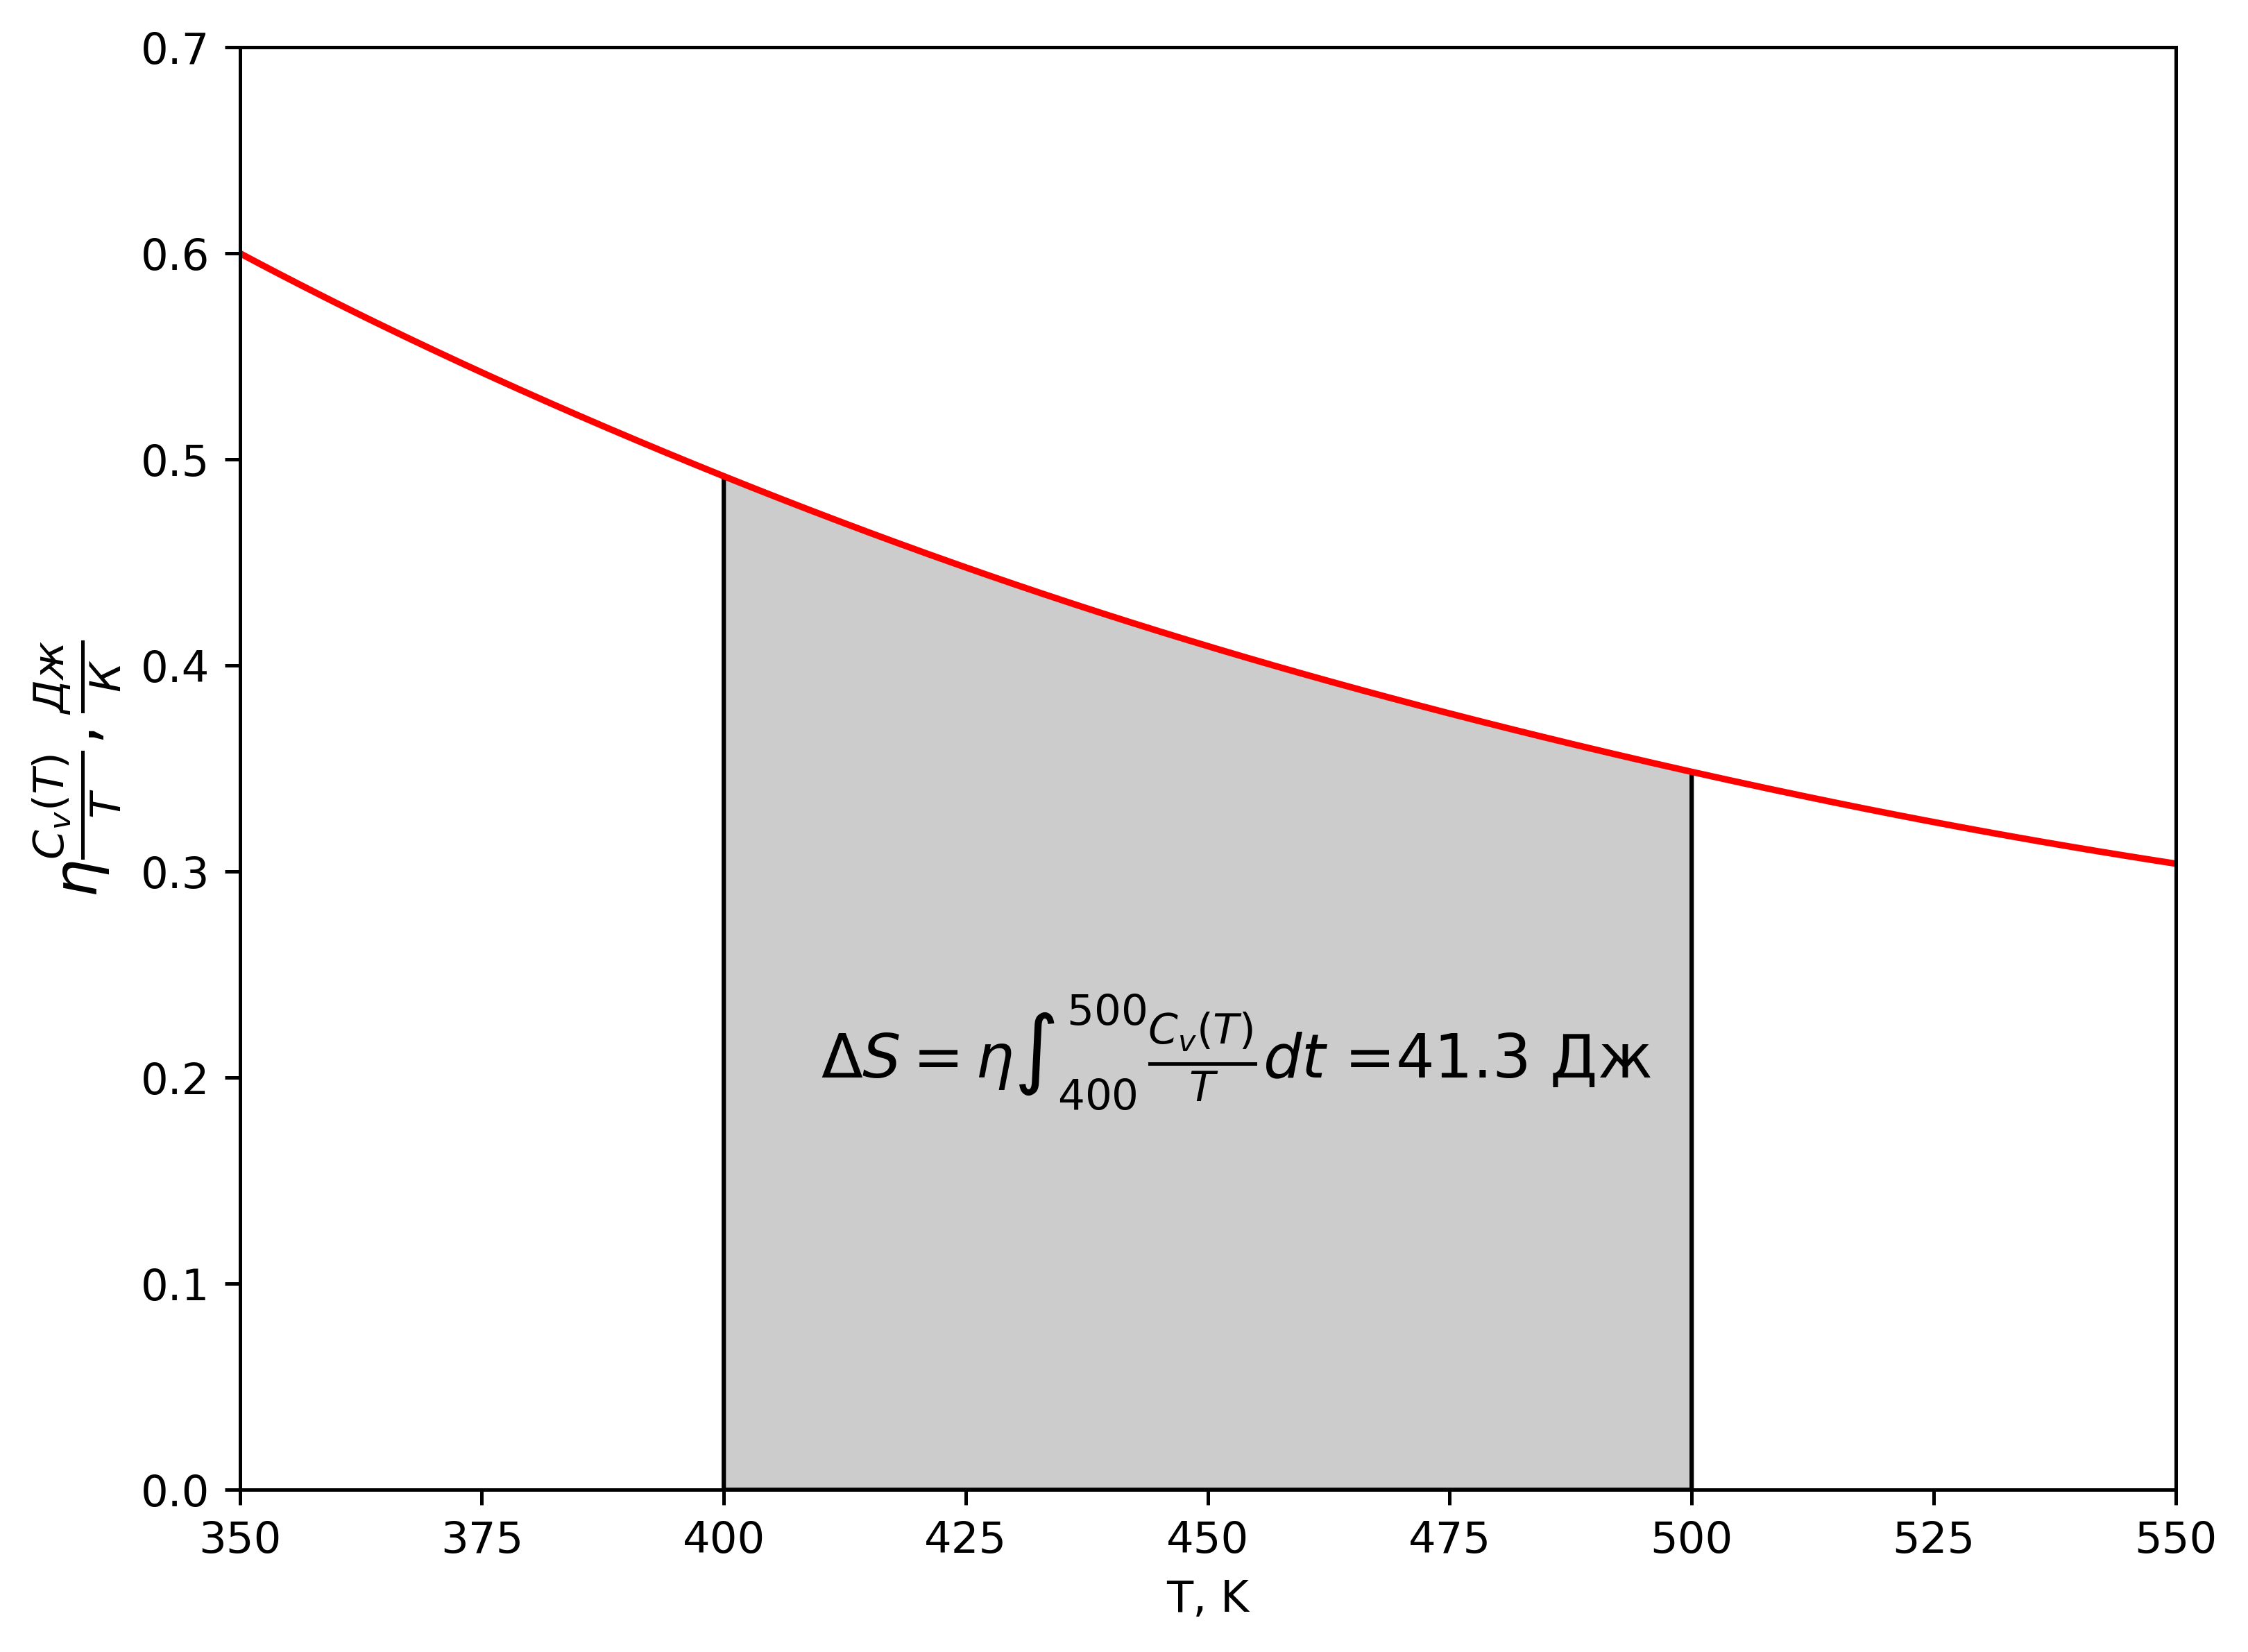

In [8]:
xlim = [350, 550]
ylim = [0, 0.7]
fig = plt.figure(figsize=(8,6), dpi=450)
ax = fig.add_subplot(xlim=xlim, ylim=ylim)

ax.plot(t_space, der, 'r')

verts = [(400, 0), *zip(t_space_window, der_window), (500, 0)]
poly = Polygon(verts, facecolor='0.8', edgecolor='0')
ax.add_patch(poly)
ax.text(410, 0.2, '$\\Delta S = \\eta \\int_{400}^{500}\
\\frac{C_v(T)}{T}dt$ =' + f'{area[0]:.1f} Дж', fontsize=14)
ax.set_ylabel('$\\eta\\frac{C_v(T)}{T}, \\frac{Дж}{К}$', fontsize=14)
ax.set_xlabel('T, K');